<a href="https://colab.research.google.com/github/saxonmahar/Deeplearning/blob/main/DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        prob_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return prob_h, torch.bernoulli(prob_h)

    def sample_v(self, h):
        prob_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return prob_v, torch.bernoulli(prob_v)

    def forward(self, v):
        prob_h, h = self.sample_h(v)
        prob_v, v_sample = self.sample_v(h)
        return v_sample

    def contrastive_divergence(self, v, k=1, lr=0.01):
        v0 = v
        for _ in range(k):
            prob_h0, h0 = self.sample_h(v0)
            prob_v, v0 = self.sample_v(h0)
        prob_hk, hk = self.sample_h(v0)

        # Weight update
        self.W.data += lr * (torch.matmul(prob_h0.t(), v) - torch.matmul(prob_hk.t(), v0)) / v.size(0)
        self.v_bias.data += lr * torch.sum(v - v0, dim=0) / v.size(0)
        self.h_bias.data += lr * torch.sum(prob_h0 - prob_hk, dim=0) / v.size(0)


In [8]:
import torch
from torch.utils.data import DataLoader

def _get_x(batch):
    return batch[0] if isinstance(batch, (list, tuple)) else batch

class DBN(nn.Module):
    def __init__(self, layers):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    def pretrain(self, train_loader, epochs=5, lr=0.01, batch_size=64, k=1, binarize_input=True):
        current_loader = train_loader
        for layer_idx, rbm in enumerate(self.rbms):
            print(f"\n=== Training RBM Layer {layer_idx+1}/{len(self.rbms)} ===")
            xs = []
            for batch in current_loader:
                x = _get_x(batch).view(batch[0].size(0), -1) if isinstance(batch, (list, tuple)) else batch.view(batch.size(0), -1)
                if layer_idx == 0 and binarize_input:
                    x = torch.bernoulli(x)
                xs.append(x)
            X = torch.cat(xs, dim=0)

            for epoch in range(1, epochs+1):
                perm = torch.randperm(X.size(0))
                for start in range(0, X.size(0), batch_size):
                    v_batch = X[perm[start:start+batch_size]]
                    rbm.contrastive_divergence(v_batch, k=k, lr=lr)
                print(f"RBM Layer {layer_idx+1}, Epoch [{epoch}/{epochs}] done.")


            with torch.no_grad():
                h_list = []
                for start in range(0, X.size(0), batch_size):
                    prob_h, _ = rbm.sample_h(X[start:start+batch_size])
                    h_list.append(prob_h)
                H = torch.cat(h_list, dim=0)
            current_loader = DataLoader(H, batch_size=batch_size, shuffle=True)


In [9]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [11]:
dbn = DBN(layers=[784, 256, 64])
dbn.pretrain(train_loader, epochs=5, lr=0.01)



=== Training RBM Layer 1/2 ===
RBM Layer 1, Epoch [1/5] done.
RBM Layer 1, Epoch [2/5] done.
RBM Layer 1, Epoch [3/5] done.
RBM Layer 1, Epoch [4/5] done.
RBM Layer 1, Epoch [5/5] done.

=== Training RBM Layer 2/2 ===
RBM Layer 2, Epoch [1/5] done.
RBM Layer 2, Epoch [2/5] done.
RBM Layer 2, Epoch [3/5] done.
RBM Layer 2, Epoch [4/5] done.
RBM Layer 2, Epoch [5/5] done.


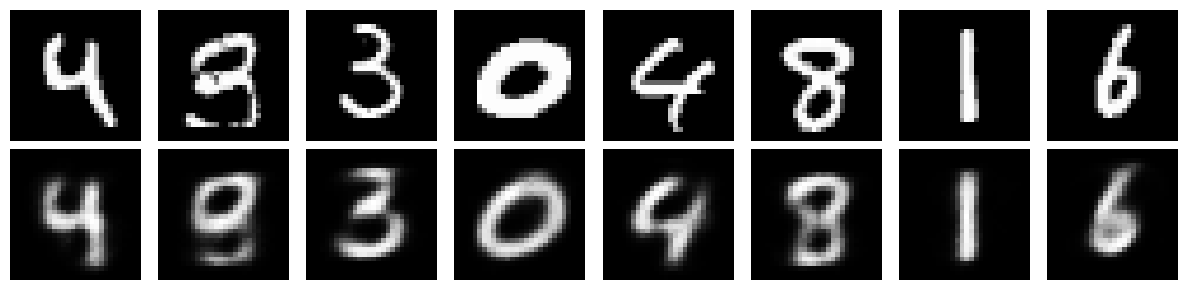

In [14]:
import torch
import matplotlib.pyplot as plt

def show_reconstruction(dbn, data_loader, n=8, use_samples=False, device=None):
    """
    Visualize DBN reconstructions.
    - n: number of examples to display.
    - use_samples: if True, sample Bernoulli states; else use probabilities (smoother).
    """
    dbn.eval()
    if device is None:
        device = next(dbn.parameters()).device


    x, _ = next(iter(data_loader))
    x = x.to(device).view(x.size(0), -1)
    x_in = x[:n]

    with torch.no_grad():

        h = x_in
        for rbm in dbn.rbms:
            prob_h, h_sample = rbm.sample_h(h)
            h = h_sample if use_samples else prob_h


        v = h
        for rbm in reversed(dbn.rbms):
            prob_v, v_sample = rbm.sample_v(v)
            v = v_sample if use_samples else prob_v


    x_plot = x_in.detach().cpu()
    v_plot = v.detach().cpu()

    fig, axes = plt.subplots(2, n, figsize=(1.5*n, 3))
    for i in range(n):
        axes[0, i].imshow(x_plot[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(v_plot[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Input")
    axes[1, 0].set_ylabel("Recon")
    plt.tight_layout()
    plt.show()
show_reconstruction(dbn, train_loader, n=8)
